In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [3]:
df_train= pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_val= pd.read_csv('val.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test= pd.read_csv('test.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

In [4]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df_train['Sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

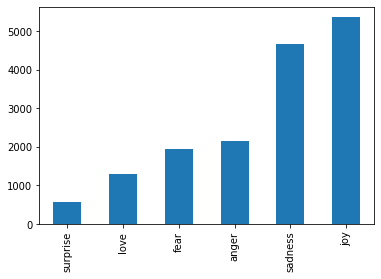

In [6]:
df_train['Sentiment'].value_counts().sort_values().plot.bar()
plt.show()

Training Dataset

In [7]:
x= df_train['Input']

In [8]:
# calculating the length of each message and making into a dataframe
lst=[]
for i in x:
  lst.append(len(i))

In [9]:
df1= pd.DataFrame(lst)
df1.describe()

,0
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [10]:
cts=[]
for i in range(7,301):
   ct=0
   for k in lst:
     if k==i:
       ct+=1
   cts.append(ct)

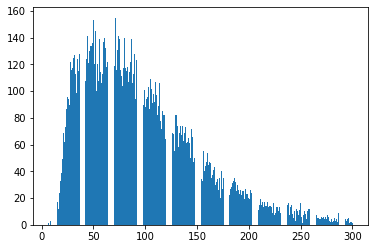

In [11]:
plt.bar(range(7, 301), cts)
plt.show()

In [12]:
# Tokenising training data set
tokenizer= Tokenizer(1512, lower=True, oov_token='UNK')
tokenizer.fit_on_texts(x)

In [13]:
# Convert text to sequences using keras
x_train= tokenizer.texts_to_sequences(x)

In [14]:
# Pad sequences to get uniform length
x_train_pad= pad_sequences(x_train, maxlen=80, padding='post')

In [15]:
# Replace the sentiments with numbers in JSON format
df_train['Sentiment']= df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [16]:
y_train= df_train['Sentiment'].values

In [17]:
# Convert to binary matrix

y_train_f= to_categorical(y_train)

In [18]:
# Printing first four rows of matrix
y_train_f[:4]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

Validation dataset


In [19]:
# Perform same steps as training data set
x_val= df_val['Input']

In [20]:
y_val= df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [21]:
x_val_f= tokenizer.texts_to_sequences(x_val)

In [22]:
x_val_pad= pad_sequences(x_val_f, maxlen=80, padding='post')

In [23]:
y_val_f= to_categorical(y_val)

Training the model using LSTM

In [24]:
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

In [25]:
# Instantiating the keras model to be Sequential
model= Sequential()

# Adding first hidden layer
model.add(Embedding(15212, 64, input_length=80))

# Dropout technique to prevent overfitting
model.add(Dropout(0.6))

# Creating LSTM layer
model.add(Bidirectional(LSTM(80, return_sequences= True)))

model.add(Bidirectional(LSTM(160)))

# Adding final hidden layer
model.add(Dense(6, activation='softmax'))

# Printing model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 64)            973568    
_________________________________________________________________
dropout (Dropout)            (None, 80, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 160)           92800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 320)               410880    
_________________________________________________________________
dense (Dense)                (None, 6)                 1926      
Total params: 1,479,174
Trainable params: 1,479,174
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
# Compiling model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Building and training the model
hist= model.fit(x_train_pad, y_train_f, epochs=12, validation_data=(x_val_pad, y_val_f))

Epoch 1/12
500/500 [==============================] - 219s 427ms/step - loss: 1.4783 - accuracy: 0.4017 - val_loss: 0.6266 - val_accuracy: 0.7930
Epoch 2/12
500/500 [==============================] - 211s 423ms/step - loss: 0.5611 - accuracy: 0.8102 - val_loss: 0.3880 - val_accuracy: 0.8710
Epoch 3/12
500/500 [==============================] - 210s 420ms/step - loss: 0.3658 - accuracy: 0.8766 - val_loss: 0.2941 - val_accuracy: 0.8950
Epoch 4/12
500/500 [==============================] - 211s 422ms/step - loss: 0.2840 - accuracy: 0.8969 - val_loss: 0.2631 - val_accuracy: 0.8935
Epoch 5/12
500/500 [==============================] - 210s 420ms/step - loss: 0.2389 - accuracy: 0.9084 - val_loss: 0.2361 - val_accuracy: 0.9055
Epoch 6/12
500/500 [==============================] - 211s 421ms/step - loss: 0.2137 - accuracy: 0.9158 - val_loss: 0.2274 - val_accuracy: 0.8960
Epoch 7/12
500/500 [==============================] - 213s 425ms/step - loss: 0.2001 - accuracy: 0.9205 - val_loss: 0.2130 -

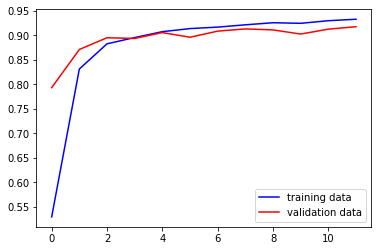

In [29]:
# Plotting accuracy of training vs validation
plt.plot(hist.history['accuracy'], c='b', label='training data')
plt.plot(hist.history['val_accuracy'], c='r', label='validation data')
plt.legend(loc='lower right')
plt.show()

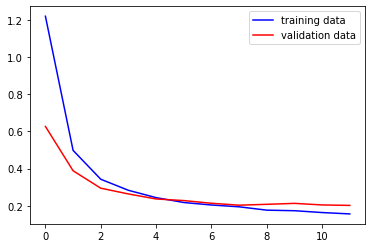

In [31]:
# Plotting loss of training vs validation
plt.plot(hist.history['loss'], c='b', label='training data')
plt.plot(hist.history['val_loss'], c='r', label='validation data')
plt.legend(loc='upper right')
plt.show()

Test dataset

In [32]:
# Same steps as training/ validation dataset 
x_test= df_test['Input']

In [33]:
y_test= df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [34]:
x_test_f= tokenizer.texts_to_sequences(x_test)

In [35]:
x_test_pad= pad_sequences(x_test_f, maxlen=80, padding='post')

In [36]:
y_test_f= to_categorical(y_test)

In [37]:
# Evaluate model
model.evaluate(x_test_pad, y_test_f)

63/63 [==============================] - 8s 127ms/step - loss: 0.1980 - accuracy: 0.9110


[0.19800475239753723, 0.9110000133514404]

**Accuracy on test data is 91.1 %**

In [38]:
# Predict model for test data
y_pred= model.predict_classes(x_test_pad)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [39]:
# Print precision, recall & f1 score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       695
           1       0.94      0.86      0.90       275
           2       0.76      0.86      0.81       159
           3       0.96      0.95      0.96       581
           4       0.83      0.94      0.88       224
           5       0.85      0.67      0.75        66

    accuracy                           0.91      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000

